#### Axel & Tristan

In [1]:
# Uppsetning
using Flux
using Zygote
using MLDatasets
using LinearAlgebra
using Plots
using LaTeXStrings

In [64]:

h = 3  # Final number of hidden layers
n = [100, 200, 500, 1000]  # Number of nodes in each hidden layer
setprecision(BigFloat,256)
# Initialize arrays to hold models
models_S = [] # sigmoid activation function
models_R = [] # ReLu activation function

for i in 1:h
    layers_S = []
    layers_R = []

    # Input to first hidden layer
    push!(layers_S, Dense(1 => n[i], σ))
    push!(layers_R, Dense(1 => n[i], relu))

    # Additional hidden layers
    for j in 2:i
        push!(layers_S, Dense(n[j] => n[j], σ))
        push!(layers_R, Dense(n[j] => n[j], relu))
    end

    # Output layer
    push!(layers_S, Dense(n[i] => 1))
    push!(layers_R, Dense(n[i] => 1))

    # Construct the models
    model_i_S = Chain(layers_S...)|> f64 # Here we use Float64 instead of the typical Float32 
    model_i_R = Chain(layers_R...)|> f64 # It's not possible to get more precison with Flux models

    # Store the models
    push!(models_S, model_i_S)
    push!(models_R, model_i_R)
end

display(models_S)
display(models_R)
typeof(models_S[1])


model1  = models_S[1] # 1->100->100->1 (Sigmoid)




3-element Vector{Any}:
 Chain(Dense(1 => 100, σ), Dense(100 => 1))  # 301 parameters
 Chain(Dense(1 => 200, σ), Dense(200 => 200, σ), Dense(200 => 1))  # 40_801 parameters
 Chain(Dense(1 => 500, σ), Dense(200 => 200, σ), Dense(500 => 500, σ), Dense(500 => 1))  # 292_201 parameters

3-element Vector{Any}:
 Chain(Dense(1 => 100, relu), Dense(100 => 1))  # 301 parameters
 Chain(Dense(1 => 200, relu), Dense(200 => 200, relu), Dense(200 => 1))  # 40_801 parameters
 Chain(Dense(1 => 500, relu), Dense(200 => 200, relu), Dense(500 => 500, relu), Dense(500 => 1))  # 292_201 parameters

Chain(
  Dense(1 => 100, σ),                   # 200 parameters
  Dense(100 => 1),                      # 101 parameters
)                   # Total: 4 arrays, 301 parameters, 2.602 KiB.

In [75]:
### Training

tMax=pi/2
Nt=Int(50)
tVec=collect(((range(start=0.0,stop=tMax,length=Nt)).^2)')
x1Vec= cos.(tVec).^2

loss(yM, y) = Flux.Losses.mse(yM,y)

# opt_state = Flux.setup(Adam(0.00003), model1)
opt_state = Flux.setup(Descent(0.0005), model1)
data1 = [(tVec, x1Vec)]
model1(tVec)
println("loss before=",loss(model1(tVec),x1Vec))

for epoch in 1:500000
    Flux.train!(model1, data1, opt_state) do m, x, y
        loss(m(x), y)
    end
end
println("loss after=",loss(model1(tVec),x1Vec))



loss before=0.14362804672749882


loss after=0.0004386418244888795


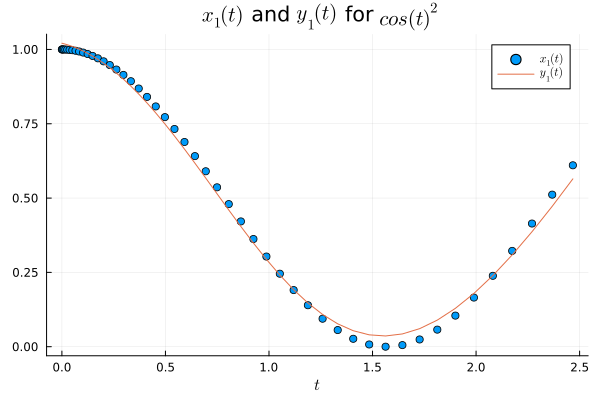

In [83]:
scatter(tVec',x1Vec',label=L"$x_1(t)$")
plot!(tVec',model1(tVec)',label=L"$y_1(t)$")
plot!(xlabel=L"$t$",title=L" $x_1(t)$ and $y_1(t)$ for $cos(t)^2$")

In [52]:
function kernel(model, x)
    """
    This function computes the "Kernel" of a given neural network
    """
    n = length(x)
    K = zeros(Float64,n, n)  # Initialize empty Kernel
   

    gs = xi-> Flux.gradient(() -> model([xi])[1],Flux.params(model)) # anonymous function
    all_grads = []
    
    # Collect numerical values
    for i in 1:n
        current_grad = []
        for j in 1:length(Flux.params(model))
            push!(current_grad, gs(x[i])[Flux.params(model)[j]])
        end
        current_grad = collect(Iterators.flatten(current_grad)) # flatten
        push!(all_grads, current_grad)
    end

    # Evaluate each K[i,j]
    for i = 1:n
        for j = 1:n
            K[i,j] = all_grads[i]'*all_grads[j] # ' means transposed
        end
    end

    return K
end

K = kernel(model1, tVec)
λ = eigen(K).values

small_λ = []
for i in range(1, length=length(λ))
    if  λ[i] < 1.0*10^(-15)
        push!(small_λ, λ[i])
    end
end

display(small_λ)

 

23-element Vector{Any}:
 -1.5555378207534817e-13
 -9.592326932761353e-14
 -5.3290705182007514e-14
 -2.842170943040401e-14
 -2.1316282072803006e-14
 -2.1316282072803006e-14
 -1.8336049008254762e-14
 -1.7763568394002505e-14
 -1.712439021248905e-14
 -1.4210854715202004e-14
  ⋮
 -5.156170375527602e-15
 -5.066677353052712e-15
 -4.711786904971529e-15
 -4.4633695052132006e-15
 -3.552713678800501e-15
 -3.552713678800501e-15
  0.0
  0.0
  7.991431807649916e-16

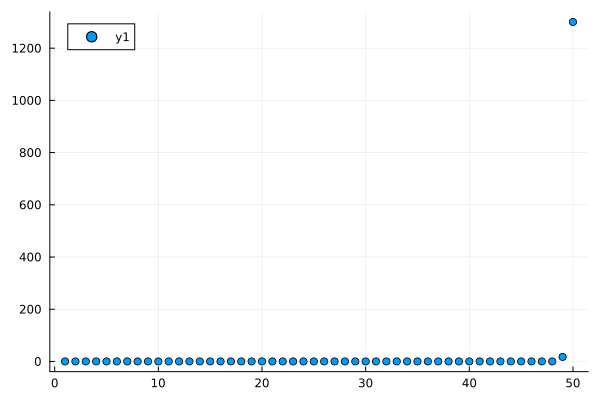

In [51]:
scatter(1:length(λ),λ)

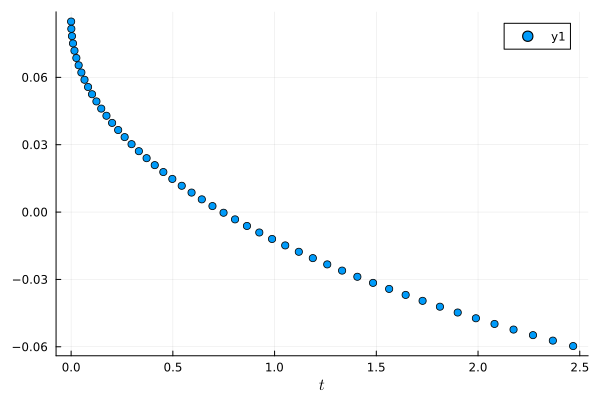

attempt to save state beyond implementation limit


In [121]:
function df(K,model,x,y)
    fθ = model1(x)
    
    Δ = K*(fθ-y)'

    return Δ
end

Δ = df(K,model1,tVec,x1Vec)

scatter(tVec',Δ)
plot!(xlabel=L"$t$")


In [164]:
function dθ_dt(K,x,y)
    θ_list = []
    for i in 1:length(x)
            
        push!(θ_list, K[i,:]*(x[i]-x1Vec[i]))
        
    end
    dθ = -sum(θ_list)
   return dθ
end


x = model1(tVec)

Δθ = dθ_dt(K,x,x1Vec)

50-element Vector{Float64}:
 -0.08486042915632974
 -0.0816125967077046
 -0.0783648208246952
 -0.07511799147461629
 -0.07187299777208533
 -0.0686307269749491
 -0.06539206348434967
 -0.062157887851411076
 -0.058929075792887975
 -0.05570649721815846
  ⋮
  0.039538526114403005
  0.04215244378018257
  0.04473928695936147
  0.04729878940779253
  0.04983070579167359
  0.05233481146980856
  0.05481090224972096
  0.057258794119093404
  0.059678322953771845